# Data cleaning

Goal : develop an application to suggest a better product according to the nutrition grade.

We will focus on product sold in France.

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Utils

In [2]:
def nb_col_rows(df):
    N = len(df)
    variables = df.columns
    nb_variables = len(variables)
    print(f'N: {N}', f'Number of variables: {nb_variables}', sep='\t')
    return N, nb_variables

def missing_percentage(df, variable):
    return len(df[df[variable].isna()])/len(df)

def completion(df, variable):
    res = missing_percentage(df, variable)
    print(f'Completion of variable \'{variable}\': {round((1-res)*100, 2)}%')

def is_number(df, variable):
    return df.dtypes[variable] == 'float'

def value_counts(df, variable):
    return df[variable].value_counts()

def missing_values(df):
    nb_na = df.isnull().sum()
    return nb_na[nb_na>0]

def box_plot(df, variable):
    df.boxplot(column=variable, vert=False)
    plt.show()

def pie_chart(df, variable):
    df[variable].value_counts(normalize=True).plot(kind='pie')
    plt.axis('equal') 
    plt.show()

def hist(df, variable):
    df[variable].hist(density=True)
    plt.show()

In [3]:
df = pd.read_csv('data/products.csv', sep='\t')

/tmp/ipykernel_3888/3047720778.py:1: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/products.csv', sep='\t')


## First sight

In [4]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
nb_col_rows(df)

N: 320772	Number of variables: 162


(320772, 162)

In [6]:
variables = df.columns
list(variables)

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_fr',
 'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_fr',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_fr',
 'ingredients_text',
 'allergens',
 'allergens_fr',
 'traces',
 'traces_tags',
 'traces_fr',
 'serving_size',
 'no_nutriments',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_fr',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil',
 'ingredients_that_may_be_from_palm_oil_tags',
 'nutritio

## Data preprocessing

### Variable selection

Keeping only products sold in France

In [7]:
res = completion(df, 'countries_fr')

Completion of variable 'countries_fr': 99.91%


In [8]:
df_fr = df[df['countries_fr'].fillna('').str.contains('France')]
nb_col_rows(df_fr)

N: 98440	Number of variables: 162


(98440, 162)

Target variable : 'nutrition_grade_df'

In [9]:
print(f'Target variable: \'nutrition_grade_fr\'')
res = completion(df, 'nutrition_grade_fr')

Target variable: 'nutrition_grade_fr'
Completion of variable 'nutrition_grade_fr': 68.96%


In [10]:
df_fr = df_fr[~df_fr['nutrition_grade_fr'].isna()]
df_fr = df_fr[~df_fr['code'].isna()]
nb_col_rows(df_fr)

N: 61415	Number of variables: 162


(61415, 162)

Keeping relevant and complete variables (up to 50%)

In [11]:
for variable in variables:
    completion(df_fr, variable)

Completion of variable 'code': 100.0%
Completion of variable 'url': 100.0%
Completion of variable 'creator': 100.0%
Completion of variable 'created_t': 100.0%
Completion of variable 'created_datetime': 100.0%
Completion of variable 'last_modified_t': 100.0%
Completion of variable 'last_modified_datetime': 100.0%
Completion of variable 'product_name': 99.44%
Completion of variable 'generic_name': 48.3%
Completion of variable 'quantity': 74.24%
Completion of variable 'packaging': 68.39%
Completion of variable 'packaging_tags': 68.39%
Completion of variable 'brands': 99.44%
Completion of variable 'brands_tags': 99.44%
Completion of variable 'categories': 72.45%
Completion of variable 'categories_tags': 72.45%
Completion of variable 'categories_fr': 72.45%
Completion of variable 'origins': 16.61%
Completion of variable 'origins_tags': 16.6%
Completion of variable 'manufacturing_places': 32.29%
Completion of variable 'manufacturing_places_tags': 32.29%
Completion of variable 'labels': 44.69

In [12]:
df_fr['main_category_fr'].head(60)
df_fr['packaging'].head(60)
df_fr['additives'].head(60)
df_fr['pnns_groups_1'].head(60)
df_fr['pnns_groups_1'].value_counts()


pnns_groups_1
Sugary snacks              7391
unknown                    7223
Milk and dairy products    5154
Cereals and potatoes       5145
Composite foods            5045
Fish Meat Eggs             4626
Beverages                  4445
Fat and sauces             2845
Fruits and vegetables      2722
Salty snacks               1830
fruits-and-vegetables       426
sugary-snacks               377
cereals-and-potatoes          1
Name: count, dtype: int64

In [13]:
keep_var = [
    'code',
    'product_name',
    'brands',
    'nutrition_grade_fr',
    'pnns_groups_1',
    'pnns_groups_2',
    'packaging',
    'ingredients_text',
    'additives',
    'ingredients_from_palm_oil_n'
]

for variable in df.columns:
    if '100g' in variable and missing_percentage(df_fr, variable)<0.30:
        keep_var.append(variable)
keep_var.remove('nutrition-score-uk_100g')
print(f'Number of relevant variables: {len(keep_var)}')

Number of relevant variables: 20


In [14]:
keep_var

['code',
 'product_name',
 'brands',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'packaging',
 'ingredients_text',
 'additives',
 'ingredients_from_palm_oil_n',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'nutrition-score-fr_100g']

Droping duplicates

In [15]:
df_relevant_with_dupl = df_fr[keep_var]
print('Before droping duplicates :')
N1, x = nb_col_rows(df_relevant_with_dupl)

Before droping duplicates :
N: 61415	Number of variables: 20


In [16]:

print('After droping duplicates :')
df_relevant=df_relevant_with_dupl.drop_duplicates(subset=['code'])
df_relevant=df_relevant.drop_duplicates(subset=['product_name', 'brands'])
df_relevant.reset_index(drop=True, inplace=True)
N2, x = nb_col_rows(df_relevant)
print(f"Number of duplicates deleted: {N1-N2}")

After droping duplicates :
N: 59198	Number of variables: 20
Number of duplicates deleted: 2217


### Missing values

In [17]:
missing_values(df_relevant)

product_name                     155
brands                           210
pnns_groups_1                  13922
pnns_groups_2                  13831
packaging                      18831
ingredients_text               19778
additives                      19786
ingredients_from_palm_oil_n    19778
energy_100g                       77
fat_100g                       16812
saturated-fat_100g                77
carbohydrates_100g             16866
sugars_100g                       77
fiber_100g                     15863
proteins_100g                     77
salt_100g                         77
sodium_100g                       77
dtype: int64

In [18]:
df_final = df_relevant.copy()

#### Qualitative variables

In [19]:
for key in ['product_name', 'brands', 'pnns_groups_1', 'pnns_groups_2', 'packaging', 'ingredients_text', 'additives']:
    df_final.fillna({key: ''}, inplace=True)
df_final.replace('unknown', '')
missing_values(df_final)

ingredients_from_palm_oil_n    19778
energy_100g                       77
fat_100g                       16812
saturated-fat_100g                77
carbohydrates_100g             16866
sugars_100g                       77
fiber_100g                     15863
proteins_100g                     77
salt_100g                         77
sodium_100g                       77
dtype: int64

In [20]:
missing_values(df_final)

ingredients_from_palm_oil_n    19778
energy_100g                       77
fat_100g                       16812
saturated-fat_100g                77
carbohydrates_100g             16866
sugars_100g                       77
fiber_100g                     15863
proteins_100g                     77
salt_100g                         77
sodium_100g                       77
dtype: int64

#### Palm Oil

In [21]:
df_final['ingredients_from_palm_oil_n'].value_counts()

ingredients_from_palm_oil_n
0.0    36346
1.0     3032
2.0       42
Name: count, dtype: int64

In [22]:
len(df_final[(df_final['ingredients_from_palm_oil_n']==2) & (df_final['additives'].str.contains('palm'))])

42

In [23]:
df_final['ingredients_from_palm_oil_n']=df_final['ingredients_from_palm_oil_n'].replace(2,1)

In [24]:
len(df_final[(df_final['ingredients_from_palm_oil_n'] == 0) & (df_final['additives'].str.contains('palm'))])

322

In [25]:
len(df_final[(df_final['ingredients_from_palm_oil_n'].isnull()) & (df_final['additives'].str.contains('palm'))])

0

In [26]:
df_final['ingredients_from_palm_oil_n']=df_final[(df_final['ingredients_from_palm_oil_n'] == 0) & (df_final['additives'].str.contains('palm'))]['ingredients_from_palm_oil_n'].replace(0,1)
df_final['ingredients_from_palm_oil_n'].fillna(0, inplace=True)

/tmp/ipykernel_3888/1788657335.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['ingredients_from_palm_oil_n'].fillna(0, inplace=True)


In [27]:
df_final['ingredients_from_palm_oil_n'].value_counts()

ingredients_from_palm_oil_n
0.0    58876
1.0      322
Name: count, dtype: int64

In [28]:
df_final.rename(columns={'ingredients_from_palm_oil_n': 'palm_oil'})

,code,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,packaging,ingredients_text,additives,palm_oil,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
0,36252,Lion Peanut x2,Sunridge,e,unknown,unknown,,"Milk chocolate coating (evaporated cane juice,...",[ milk-chocolate-coating -> en:milk-chocolate...,0.0,1883.0,20.0,12.50,70.0,57.50,2.5,2.50,0.09652,0.038000,22.0
1,10187319,Mini Confettis,Alice Délice,d,,,,,,0.0,1753.0,NaN,0.80,NaN,87.70,0.9,0.60,0.01000,0.003937,14.0
2,10207260,Praliné Amande Et Noisette,Alice Délice,d,,,,,,0.0,2406.0,NaN,2.90,NaN,50.30,3.9,9.50,0.00300,0.001181,14.0
3,40608754,"Pepsi, Nouveau goût !",Pepsi,e,Beverages,Sweetened beverages,Canette aluminium,"Eau gazéifiée, sucre, colorant caramel E150d, ...",[ eau-gazeifiee -> fr:eau-gazeifiee ] [ eau...,0.0,177.0,0.0,0.00,10.4,10.40,0.0,0.00,0.02540,0.010000,13.0
4,69161025,Tarte Poireaux Et Lardons,Bo Frost,d,,,,,,0.0,1079.0,NaN,11.00,NaN,1.00,1.4,7.50,0.80000,0.314961,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59193,9782211109758,Verrine Cheescake Myrtille,Kayser,d,,,,,,0.0,1084.0,NaN,12.00,NaN,10.50,0.0,8.70,0.29000,0.114173,16.0
59194,9782401029101,Fiche Brevet,Hatier,b,,,,,,0.0,4.0,NaN,1.00,NaN,1.00,10.0,10.00,10.00000,3.937008,0.0
59195,9847548283004,Tartines craquantes bio au sarrasin,Le Pain des fleurs,a,Cereals and potatoes,Bread,"Boîte,Carton,Sachet,Plastique",,,0.0,1643.0,2.8,0.60,74.8,2.60,5.9,13.00,0.68000,0.267717,-4.0
59196,9900000000233,Amandes,Biosic,b,,,,,,0.0,2406.0,NaN,3.73,NaN,3.89,12.2,21.22,0.10000,0.039370,0.0


#### Quantitative variables

In [29]:
missing_values(df_final)

energy_100g              77
fat_100g              16812
saturated-fat_100g       77
carbohydrates_100g    16866
sugars_100g              77
fiber_100g            15863
proteins_100g            77
salt_100g                77
sodium_100g              77
dtype: int64

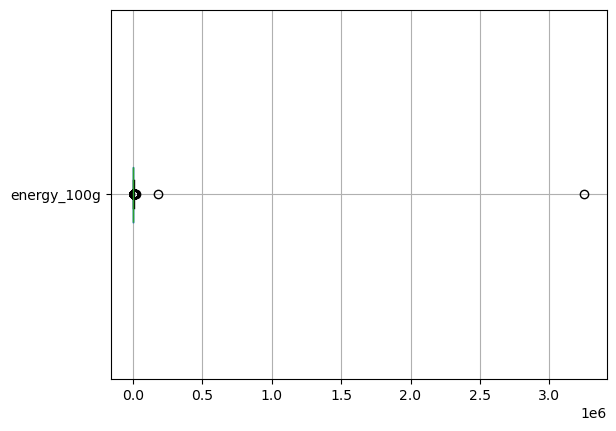

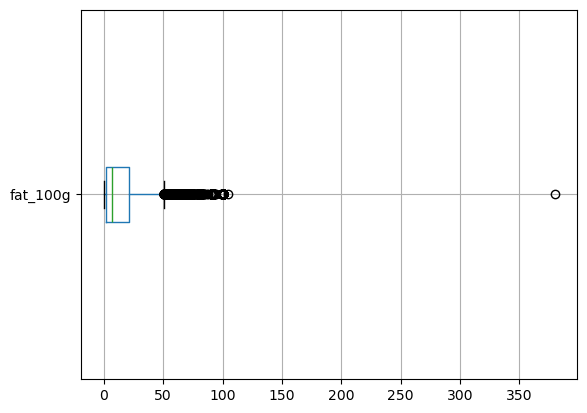

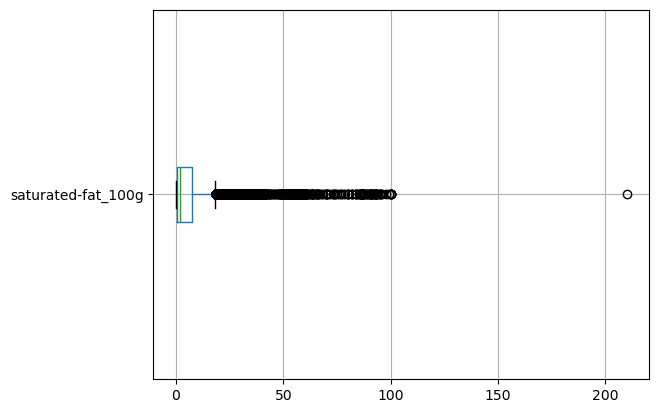

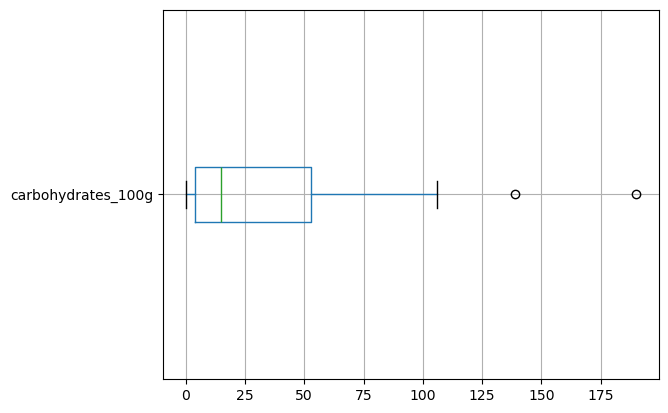

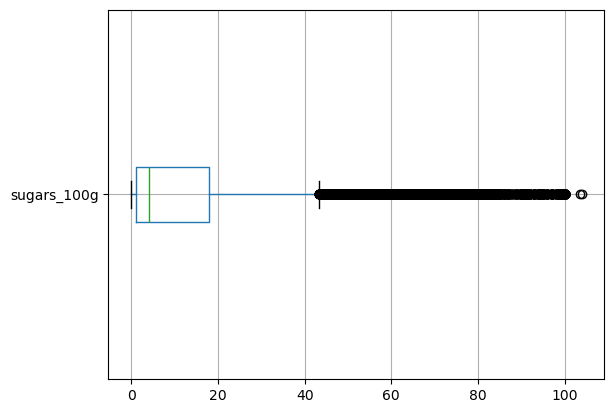

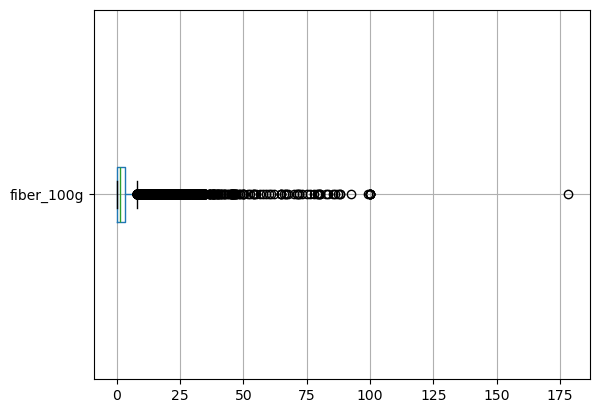

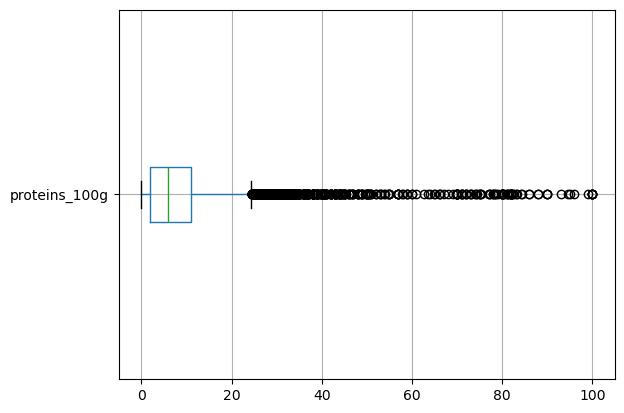

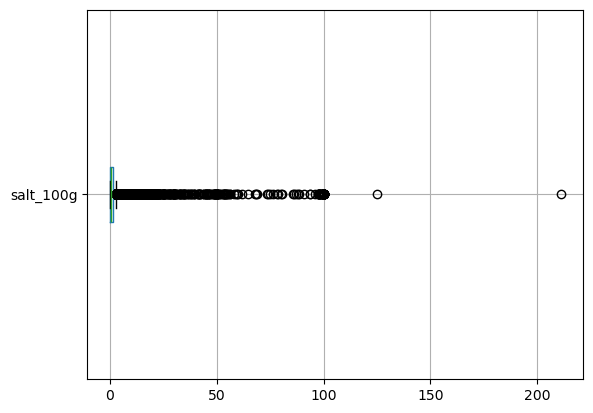

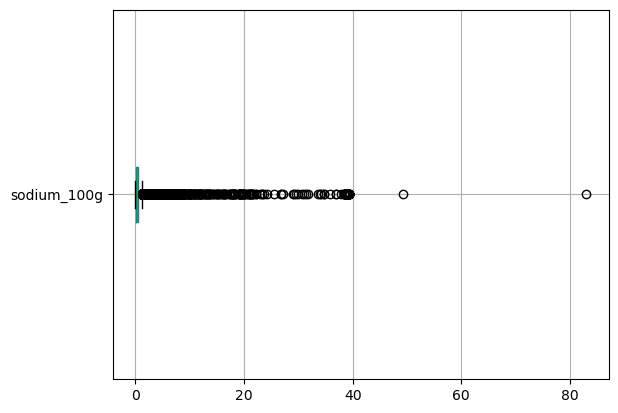

In [30]:
for variable in ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']:
    df_final.boxplot(column=variable, vert=False)
    plt.show()

#### Fibers

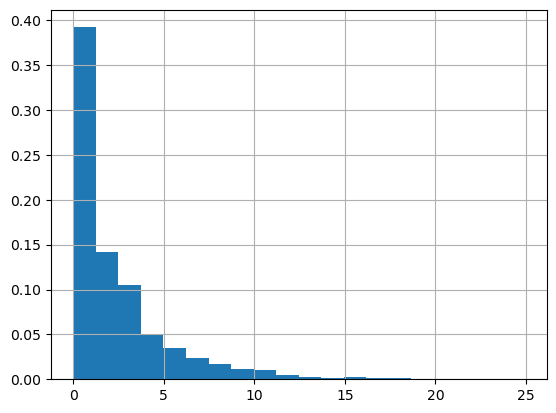

In [31]:
df_final[df_final['fiber_100g']<25]['fiber_100g'].hist(density=True, bins=20)
plt.show()

In [32]:
df_final.fillna({'fiber_100g': 0}, inplace=True)

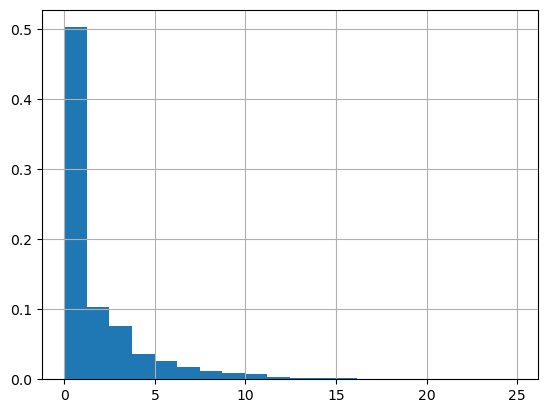

In [33]:
df_final[df_final['fiber_100g']<25]['fiber_100g'].hist(density=True, bins=20)
plt.show()

#### Sodium and Salt

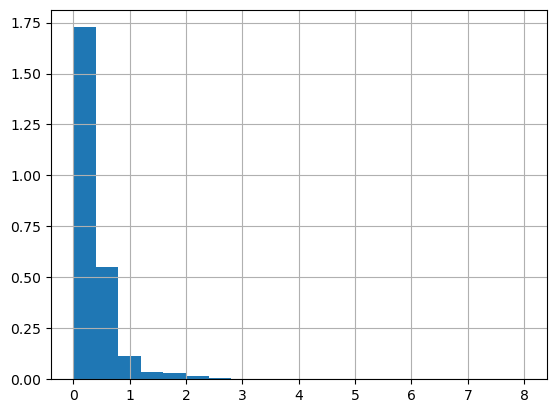

In [34]:
df_final['sodium_100g'].hist(density=True, bins=20, range=(0,8))
#df_final['salt_100g'].hist(density=True, bins=20, range=(0,8))
plt.show()

In [35]:
df_final.drop('sodium_100g', axis=1)

,code,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,packaging,ingredients_text,additives,ingredients_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition-score-fr_100g
0,36252,Lion Peanut x2,Sunridge,e,unknown,unknown,,"Milk chocolate coating (evaporated cane juice,...",[ milk-chocolate-coating -> en:milk-chocolate...,0.0,1883.0,20.0,12.50,70.0,57.50,2.5,2.50,0.09652,22.0
1,10187319,Mini Confettis,Alice Délice,d,,,,,,0.0,1753.0,NaN,0.80,NaN,87.70,0.9,0.60,0.01000,14.0
2,10207260,Praliné Amande Et Noisette,Alice Délice,d,,,,,,0.0,2406.0,NaN,2.90,NaN,50.30,3.9,9.50,0.00300,14.0
3,40608754,"Pepsi, Nouveau goût !",Pepsi,e,Beverages,Sweetened beverages,Canette aluminium,"Eau gazéifiée, sucre, colorant caramel E150d, ...",[ eau-gazeifiee -> fr:eau-gazeifiee ] [ eau...,0.0,177.0,0.0,0.00,10.4,10.40,0.0,0.00,0.02540,13.0
4,69161025,Tarte Poireaux Et Lardons,Bo Frost,d,,,,,,0.0,1079.0,NaN,11.00,NaN,1.00,1.4,7.50,0.80000,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59193,9782211109758,Verrine Cheescake Myrtille,Kayser,d,,,,,,0.0,1084.0,NaN,12.00,NaN,10.50,0.0,8.70,0.29000,16.0
59194,9782401029101,Fiche Brevet,Hatier,b,,,,,,0.0,4.0,NaN,1.00,NaN,1.00,10.0,10.00,10.00000,0.0
59195,9847548283004,Tartines craquantes bio au sarrasin,Le Pain des fleurs,a,Cereals and potatoes,Bread,"Boîte,Carton,Sachet,Plastique",,,0.0,1643.0,2.8,0.60,74.8,2.60,5.9,13.00,0.68000,-4.0
59196,9900000000233,Amandes,Biosic,b,,,,,,0.0,2406.0,NaN,3.73,NaN,3.89,12.2,21.22,0.10000,0.0


### Protein, Sugar, Saturated fat, Salt

In [36]:
mask = df_final['proteins_100g'].isna() & df_final['sugars_100g'].isna() & df_final['saturated-fat_100g'].isna()
print(df_final.loc[mask, :].shape[0])
df_final.loc[mask, :].head()

77


,code,product_name,brands,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,packaging,ingredients_text,additives,ingredients_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
177,24463061163,Sriracha Hot Chili Sauce,"Huy Fong foods, Huy Fong Foods Inc.",b,Fat and sauces,Dressings and sauces,plastic bottle,"Chili, Sugar, Salt, Garlic, Distilled Vinegar,...",[ chili -> en:chili ] [ sugar -> en:sugar ...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
302,41500053448,Classic Yellow,French's,b,Fat and sauces,Dressings and sauces,"Plastique,Flacon","vinaigre, eau, graines de moutarde, sel, papri...",[ vinaigre -> fr:vinaigre ] [ eau -> fr:eau...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
315,42272010516,Nouilles chinoises et légumes,Amy's kitchen,b,Composite foods,One-dish meals,,,,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
626,87703168787,Mirin,Sukina,b,,Alcoholic beverages,Bouteille,"Fructose, Glucose, Sorbitol-D, Vinaigre, Sucre...",[ fructose -> fr:fructose ] [ glucose -> fr...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
681,949453,Sparkling Scottish Mountain Water,Marks & Spencer,b,Beverages,Non-sugared beverages,"Bouteille,Plastique",eau,[ eau -> fr:eau ],0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0


In [37]:
df_final.dropna(subset=['proteins_100g'], inplace=True)

In [38]:
missing_values(df_final)

fat_100g              16735
carbohydrates_100g    16789
dtype: int64

#### Carbohydrates, Fat

In [39]:
mask = (~df_final['carbohydrates_100g'].isna() & df_final['fat_100g'].isna()) | (df_final['carbohydrates_100g'].isna() & ~df_final['fat_100g'].isna())
df_final.loc[mask, :].shape[0]

224

Median of carbohydrates_100g: 15.0


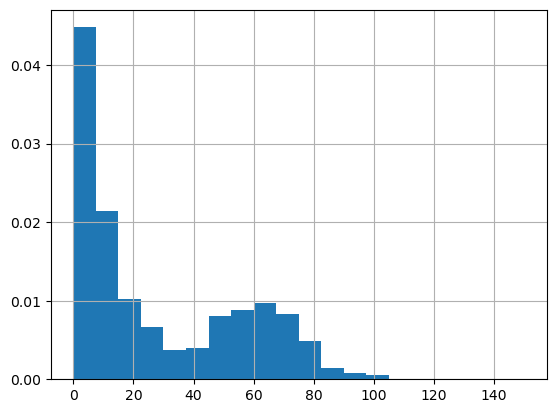

Median of fat_100g: 7.0


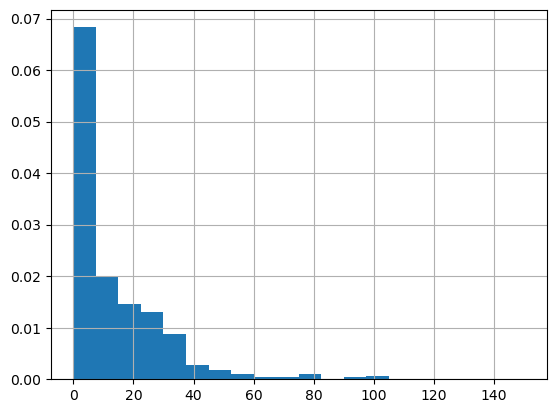

In [40]:
for var in ['carbohydrates_100g', 'fat_100g']:
    print(f'Median of {var}: {df_final[var].median()}')
    df_final[var].hist(density=True, bins=20, range=(0,150))
    plt.show()

In [41]:
df_final.groupby(['pnns_groups_1'])[['carbohydrates_100g', 'fat_100g']].std()

,carbohydrates_100g,fat_100g
pnns_groups_1,,
,27.287103,16.439672
Beverages,19.435535,2.702240
Cereals and potatoes,21.946965,7.589650
Composite foods,10.139740,5.284835
Fat and sauces,10.188086,36.122356
Fish Meat Eggs,3.204735,11.943700
Fruits and vegetables,19.076729,8.489372
Milk and dairy products,10.032733,11.786845
Salty snacks,20.230186,16.354829


In [42]:
df_final.groupby(['pnns_groups_2'])[['carbohydrates_100g', 'fat_100g']].std()

,carbohydrates_100g,fat_100g
pnns_groups_2,,
,27.175407,17.453212
Alcoholic beverages,5.705972,2.797812
Appetizers,15.139185,13.643736
Artificially sweetened beverages,15.823705,0.291835
Biscuits and cakes,10.473087,7.372498
Bread,13.198456,6.144182
Breakfast cereals,9.515719,6.481570
Cereals,22.326693,6.537892
Cheese,3.025530,8.963325


In [43]:
pnns_2_med_df = df_final.groupby(['pnns_groups_2'])[['carbohydrates_100g', 'fat_100g', 'energy_100g',
 'saturated-fat_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'nutrition-score-fr_100g']].median()

In [44]:
df_final.loc[df_final["carbohydrates_100g"].isna(), "pnns_groups_2"].value_counts()

pnns_groups_2
                            13526
unknown                       926
Non-sugared beverages         275
Fruit juices                  227
Sweets                        156
Cheese                        154
Biscuits and cakes            134
One-dish meals                128
Dressings and sauces          111
Cereals                       107
Milk and yogurt                93
Sweetened beverages            89
Fats                           88
Fish and seafood               85
Processed meat                 79
Chocolate products             66
Fruits                         63
Vegetables                     62
Bread                          56
Breakfast cereals              48
Appetizers                     43
Nuts                           32
Meat                           31
Dried fruits                   29
Fruit nectars                  27
Legumes                        23
pastries                       21
Alcoholic beverages            19
Dairy desserts                 19


In [45]:
# Reset index of pnns_2_med_df to ensure 'pnns_groups_2' is a column
pnns_2_med_df.reset_index(inplace=True)

# Merge based on "pnns_groups_2" to fill missing values
filled_df = pd.merge(df_final, pnns_2_med_df[['pnns_groups_2',
                    'energy_100g',
                    'fat_100g',
                    'saturated-fat_100g',
                    'carbohydrates_100g',
                    'sugars_100g',
                    'fiber_100g',
                    'proteins_100g',
                    'salt_100g',
                    'sodium_100g',
                    'nutrition-score-fr_100g']], 
                     how='left', on='pnns_groups_2', suffixes=('', '_pnns'))

# Update missing values in df_final
df_final['carbohydrates_100g'] = df_final['carbohydrates_100g'].fillna(filled_df['carbohydrates_100g_pnns'])
df_final['fat_100g'] = df_final['fat_100g'].fillna(filled_df['fat_100g_pnns'])


In [46]:
missing_values(df_final)

fat_100g              38
carbohydrates_100g    38
dtype: int64

In [47]:
df_final.dropna(inplace=True)

In [48]:
missing_values(df_final)

Series([], dtype: int64)

#### Calories

In [49]:
df_final["energy_100g"] = df_final["energy_100g"]/4.184

### Outliers

In [50]:
for i,row in df_final.iterrows():
    for variable in ['fat_100g',
                    'saturated-fat_100g',
                    'carbohydrates_100g',
                    'sugars_100g',
                    'fiber_100g',
                    'proteins_100g',
                    'salt_100g',
                    'sodium_100g',
                    'nutrition-score-fr_100g']:
        if row[variable] > 100:
            df_final.loc[i, variable] = filled_df.loc[i, f"{variable}_pnns"]
    if row["energy_100g"]>1000:
        df_final.loc[i, variable] = filled_df.loc[i, "energy_100g_pnns"]
    if row["saturated-fat_100g"] > row["fat_100g"]:
        df_final.loc[i, variable] = filled_df.loc[i, "saturated-fat_100g_pnns"]
    if row["sugars_100g"] > row["carbohydrates_100g"]:
        df_final.loc[i, variable] = filled_df.loc[i, "sugars_100g_pnns"]


In [53]:
df_final.to_csv("data/final_dataset.csv")